In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_419334/1321067960.py:20: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

haiyan_u = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
haiyan_qv = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['qv'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
haiyan_heatsum = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['heatsum'] for lime in tqdm(range(1,21))],axis=0)
haiyan_hdia = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))],axis=0)
haiyan_rad = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)
haiyan_ir = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['ir'] for lime in tqdm(range(1,21))],axis=0)

dims = ['sample','flatarray']
coords = dict(sample=np.linspace(0,haiyan_u.shape[0]-1,haiyan_u.shape[0]),flatarray=np.linspace(0,haiyan_u.shape[1]-1,haiyan_u.shape[1]))
ds = xr.Dataset(coords=coords)
haiyan_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','heatsum','hdia','rad','qv','ir'],\
                                   varfile=[haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_heatsum,haiyan_hdia,haiyan_rad,haiyan_qv,haiyan_ir],dims=dims,coords=coords)
del haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_heatsum,haiyan_hdia,haiyan_rad
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

80

In [3]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
yall = read_and_proc.depickle(folderpath+'pca/y/allY'+'_'+'dict_g')

In [4]:
from sklearn.cross_decomposition import CCA
from copy import deepcopy

In [28]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class proc_for_CCA:
    def __init__(self,var=None,yall=None,validindex=None,testindex=None,LT=None,random=False):
        self.var=var
        self.validindex=validindex
        self.testindex=testindex
        self.random=random
        self.LT=LT
        self.yall=yall
        
    def delete_padding(self,outTS=None):
        output_nozero = []
        for i in range(len(outTS[:,0])):
            temp = outTS[i,:]
            if temp.all()==0:
                continue
            else:
                output_nozero.append(temp)
        return output_nozero
    
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                else:
                    continue
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict

    def proc_var(self):
        ulist = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)[self.var] for lime in tqdm(range(1,21))]
        if self.random is False:
            [ulist.pop(i) for i in self.validindex]
            [ulist.pop(i) for i in self.testindex]
            
            ulist24 = []
            for i in range(len(ulist)):
                temp = ulist[i]
                try:
                    ulist24.append(temp[:-int(self.LT)])
                except:
                    continue
            return np.concatenate(ulist24,axis=0)
        else:
            print("Not available yet")
            
    def proc_var_timediff(self):
        ulist = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)[self.var] for lime in tqdm(range(1,21))]
        if self.random is False:
            [ulist.pop(i) for i in self.validindex]
            [ulist.pop(i) for i in self.testindex]
            dtermsT = self.get_time_diff_terms(inputvar=[ulist],LT=self.LT,wantvar=[self.var])
            return np.concatenate([testx for testx in dtermsT[self.var]],axis=0)
        else:
            print("Not available yet")
            
    def proc_target(self):
        return [np.asarray(self.delete_padding(self.yall[int(self.LT-1)][i])) for i in range(3)]

In [29]:
outU = proc_for_CCA('rad',yall,[1,6],[2,12],24,False).proc_var()
targetTRAIN = proc_for_CCA('rad',yall,[1,6],[2,12],24,False).proc_target()
duTRAIN = proc_for_CCA('u',yall,[1,6],[2,12],24,False).proc_var_timediff()
dvTRAIN = proc_for_CCA('v',yall,[1,6],[2,12],24,False).proc_var_timediff()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
duTRAIN.shape,outU.shape

((869, 748800), (869, 748800))

In [32]:
cca = CCA(n_components=10)
cca.fit(outU, np.sqrt(duTRAIN**2+dvTRAIN**2))#targetTRAIN[0])
#X_c, Y_c = cca.transform(X, Y)

MemoryError: Unable to allocate 4.08 TiB for an array with shape (748800, 748800) and data type float64

In [25]:
test = cca.x_weights_[:,0].reshape(10,360,208)

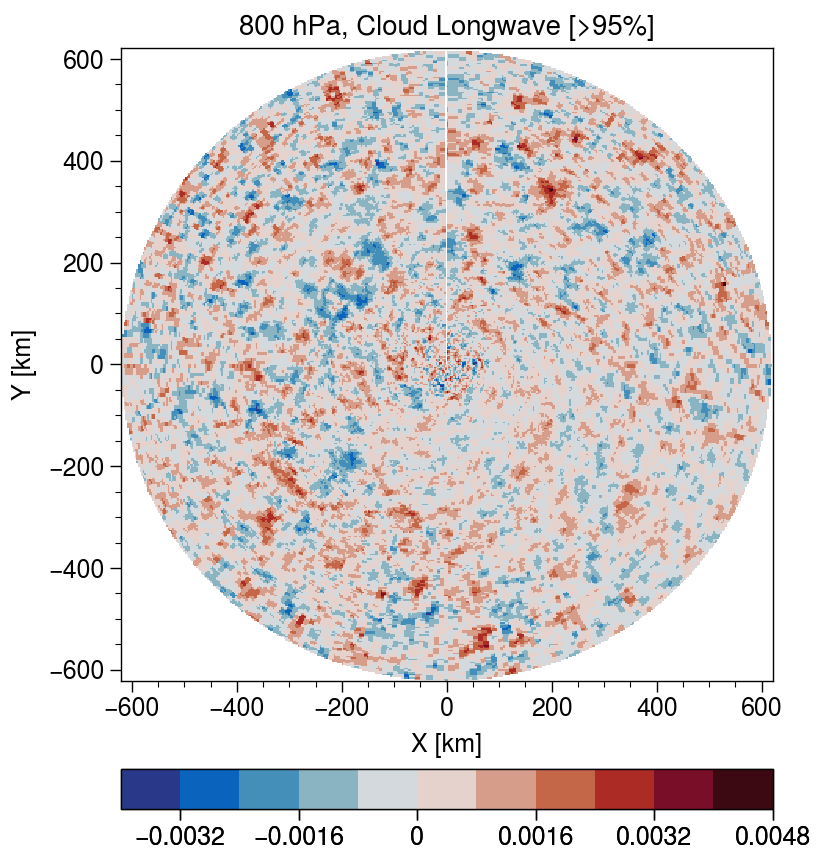

In [26]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))

indices=0
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)')
typelabel=['Cloud Longwave [>95%]','Cloud Longwave [<5%]']#['Cloud Longwave [>95%]','Cloud Longwave [<5%]']
axs[indices].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(test[0,...],ANGLE,True,False)))),0),
                        cmap='balance',colorbar='b')#,levels=np.linspace(-5,5,17))#,colorbar_kw={'format':'simple','ticks':0.0006,'label': 'PC[RAD]_2'},extend='both')
#axs[indices].streamplot(np.linspace(-207,207,416)*3,np.linspace(-207,207,416)*3,ut[indices],vt[indices], density=[1.25, 1.25],linewidth=0.5)
axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'{800} hPa, {typelabel[indices]}')
#plotting.adjust_spines(axs[indices],['left','bottom'],10)
#plt.savefig('../figures/0425/MLR_dvdtrecon_decompcheck_24hr_800_95_5_vect.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

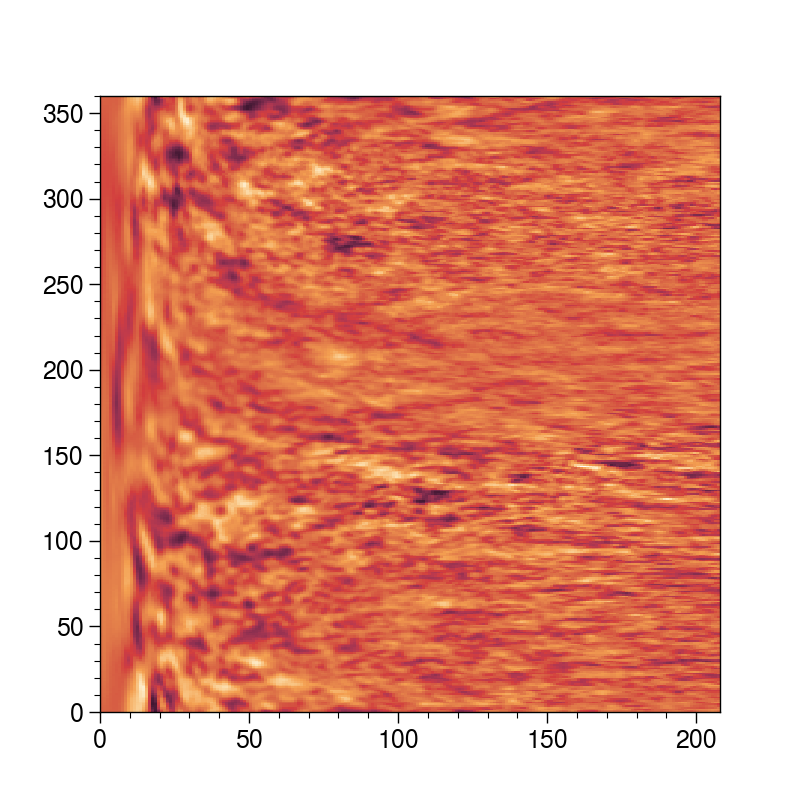

In [12]:
plt.pcolormesh(test[2,:,:])
plt.show()